In [ ]:
!pip install torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 30.7 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

In [ ]:
from transformers import CLIPTokenizer, CLIPTextModel

# Chargement du tokenizer et du modèle CLIP
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

def encode_text(text_list):
    """
    text_list : liste de chaînes (descriptions)
    Retourne les embeddings de dimension (B, L, 512) (L : longueur de la séquence)
    """
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True)
    outputs = text_encoder(**inputs)
    return outputs.last_hidden_state  # (B, L, 512)


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ImageTextDataset(Dataset):
    def __init__(self, image_dir, text_dir, transform=None, tokenizer=None):
        """
        image_dir: dossier contenant les images
        text_dir: dossier contenant les descriptions en .txt
        transform: transformations sur l'image (redimensionnement, normalisation, etc.)
        tokenizer: fonction ou objet pour encoder la description (ex: tokenizer de CLIP)
        """
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.image_names = os.listdir(image_dir)  # on suppose que le dossier contient uniquement les images
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        # Chargement de l'image
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # Lecture du fichier texte associé (nom_image.txt)
        txt_name = os.path.splitext(img_name)[0] + ".txt"
        txt_path = os.path.join(self.text_dir, txt_name)
        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        # On renvoie simplement la chaîne brute
        return image, text


# Exemple d'utilisation :
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # redimensionne l'image à 1024x1024
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageTextDataset("/content/drive/MyDrive/data_diffusion/data_prep/images", "/content/drive/MyDrive/data_diffusion/data_prep/descriptions", transform=transform, tokenizer=tokenizer)
#dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
from torch.utils.data import random_split

# Split du dataset
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        # Couche 1 : Convolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        # Calcul : (1024 - 4 + 2*1)/2 + 1 = 512  => (B, 64, 512, 512)

        # Couche 2 : Convolution
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        # Calcul : (512 - 4 + 2*1)/2 + 1 = 256  => (B, 128, 256, 256)

        # Couche 3 : Convolution
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        # Calcul : (256 - 4 + 2*1)/2 + 1 = 128  => (B, 256, 128, 128)

        # Couche 4 : Convolution
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        # Calcul : (128 - 4 + 2*1)/2 + 1 = 64   => (B, 512, 64, 64)

        # Couche 5 : Convolution pour obtenir le tenseur latent
        self.conv5 = nn.Conv2d(512, latent_dim, kernel_size=3, stride=1, padding=1)
        # Calcul : (64 - 3 + 2*1)/1 + 1 = 64   => (B, latent_dim, 64, 64)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (B, 64, 512, 512)
        x = F.relu(self.conv2(x))  # (B, 128, 256, 256)
        x = F.relu(self.conv3(x))  # (B, 256, 128, 128)
        x = F.relu(self.conv4(x))  # (B, 512, 64, 64)
        x = self.conv5(x)          # (B, latent_dim, 64, 64)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        # Couche 1 : Convolution pour passer du latent à une représentation plus riche
        self.conv1 = nn.Conv2d(latent_dim, 512, kernel_size=3, stride=1, padding=1)
        # (B, latent_dim, 64, 64) -> (B, 512, 64, 64)

        # Couche 2 : Transposed Convolution (upsampling)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        # Calcul : (64 - 1)*2 - 2*1 + 4 = 128  => (B, 256, 128, 128)

        # Couche 3 : Transposed Convolution
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        # Calcul : (128 - 1)*2 - 2*1 + 4 = 256  => (B, 128, 256, 256)

        # Couche 4 : Transposed Convolution
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        # Calcul : (256 - 1)*2 - 2*1 + 4 = 512  => (B, 64, 512, 512)

        # Couche 5 : Transposed Convolution
        self.deconv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        # Calcul : (512 - 1)*2 - 2*1 + 4 = 1024 => (B, 3, 1024, 1024)

    def forward(self, z):
        x = F.relu(self.conv1(z))       # (B, 512, 64, 64)
        x = F.relu(self.deconv1(x))       # (B, 256, 128, 128)
        x = F.relu(self.deconv2(x))       # (B, 128, 256, 256)
        x = F.relu(self.deconv3(x))       # (B, 64, 512, 512)
        x = torch.tanh(self.deconv4(x))   # (B, 3, 1024, 1024)
        return x


In [ ]:
import torch.utils.checkpoint as checkpoint
import torch.utils.checkpoint as cp


class ConvBlock(nn.Module):
    """
    Bloc de convolution avec normalisation et activation.
    Ajoute une couche de self‑attention si spécifié.
    """
    def __init__(self, in_channels, out_channels, use_attention=False, num_heads=4):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        # La convolution conserve les dimensions spatiales : (B, out_channels, H, W)
        self.norm = nn.GroupNorm(32, out_channels)
        self.activation = nn.ReLU()
        self.use_attention = use_attention
        if use_attention:
            self.self_attn = SelfAttention(out_channels, num_heads=num_heads)

    def forward(self, x):
        x = self.conv(x)
        # x : (B, out_channels, H, W)
        x = self.norm(x)
        x = self.activation(x)
        if self.use_attention:
            x = self.self_attn(x)
        return x

class SelfAttention(nn.Module):
    """
    Self‑attention appliquée sur les dimensions spatiales.
    Si H*W dépasse apply_threshold, l'attention n'est pas appliquée.
    """
    def __init__(self, in_channels, num_heads=8, apply_threshold=1024):
        super().__init__()
        self.num_heads = num_heads
        self.apply_threshold = apply_threshold  # Par exemple : appliquer seulement si H*W <= 1024
        self.norm = nn.GroupNorm(32, in_channels)
        self.qkv = nn.Conv2d(in_channels, in_channels * 3, kernel_size=1)
        self.proj_out = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        # Si la résolution est trop élevée, on ne fait pas d'attention pour économiser la mémoire.
        if H * W > self.apply_threshold:
            return x
        h = self.norm(x)
        qkv = self.qkv(h)
        # qkv : (B, 3*C, H, W)
        q, k, v = torch.chunk(qkv, 3, dim=1)
        # Reshape pour la multi‑head : (B, num_heads, C_per_head, H*W)
        q = q.reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = k.reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = v.reshape(B, self.num_heads, C // self.num_heads, H * W)
        # Calcul de l’attention
        attn = torch.einsum("bnci,bncj->bnij", q, k) / ((C // self.num_heads) ** 0.5)
        attn = torch.softmax(attn, dim=-1)
        out = torch.einsum("bnij,bncj->bnci", attn, v)
        out = out.reshape(B, C, H, W)
        out = self.proj_out(out)
        return out + x



class CrossAttention(nn.Module):
    """
    Cross‑attention pour intégrer les embeddings textuels dans le tenseur de features.
    x : (B, N, in_channels) où N = H*W
    context : (B, L, context_dim), L = longueur de la séquence textuelle
    """
    def __init__(self, in_channels, context_dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.norm = nn.LayerNorm(in_channels)
        self.q_proj = nn.Linear(in_channels, in_channels)
        self.k_proj = nn.Linear(context_dim, in_channels)
        self.v_proj = nn.Linear(context_dim, in_channels)
        self.out_proj = nn.Linear(in_channels, in_channels)

    def forward(self, x, context):
        B, N, C = x.shape
        x_norm = self.norm(x)
        q = self.q_proj(x_norm)       # (B, N, C)
        k = self.k_proj(context)      # (B, L, C)
        v = self.v_proj(context)      # (B, L, C)
        # Séparation en têtes
        q = q.view(B, N, self.num_heads, C // self.num_heads).transpose(1,2)  # (B, num_heads, N, C//num_heads)
        k = k.view(B, -1, self.num_heads, C // self.num_heads).transpose(1,2)   # (B, num_heads, L, C//num_heads)
        v = v.view(B, -1, self.num_heads, C // self.num_heads).transpose(1,2)   # (B, num_heads, L, C//num_heads)
        attn = torch.matmul(q, k.transpose(-2, -1)) / (C // self.num_heads) ** 0.5
        # attn : (B, num_heads, N, L)
        attn = torch.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)  # (B, num_heads, N, C//num_heads)
        out = out.transpose(1,2).reshape(B, N, C)  # (B, N, C)
        out = self.out_proj(out)
        return x + out




class UNetBlock(nn.Module):
    """
    Bloc U‑Net combinant un ConvBlock et, si disponible, un module de cross‑attention.
    On applique le checkpointing sur le ConvBlock et le cross‑attention.
    """
    def __init__(self, in_channels, out_channels, use_attention=False, context_dim=None, num_heads=4):
        super().__init__()
        self.conv_block = ConvBlock(in_channels, out_channels, use_attention=use_attention, num_heads=num_heads)
        if context_dim is not None:
            self.cross_attn = CrossAttention(out_channels, context_dim, num_heads=num_heads)
        else:
            self.cross_attn = None

    def forward(self, x, context=None):
      # Checkpointing avec alias 'cp'
      x = cp.checkpoint(self.conv_block, x)
      if self.cross_attn is not None and context is not None:
          B, C, H, W = x.shape
          x_flat = x.view(B, C, H * W).permute(0, 2, 1)
          x_flat = cp.checkpoint(self.cross_attn, x_flat, context)  # 'cp' ici
          x = x_flat.permute(0, 2, 1).view(B, C, H, W)
      return x

class UNet(nn.Module):
    def __init__(self, in_channels=256, base_channels=128, context_dim=512):
        """
        in_channels : dimension du latent (ex. 256)
        base_channels : nombre de canaux de base dans le U-Net
        context_dim : dimension des embeddings textuels (ex. 512 pour CLIP)
        """
        super().__init__()
        # Partie d'encodage (downsampling)
        self.down1 = UNetBlock(in_channels, base_channels, use_attention=True, context_dim=context_dim)
        # Attendu : (B,256,64,64) -> (B,128,64,64)
        self.down2 = UNetBlock(base_channels, base_channels*2, use_attention=True, context_dim=context_dim)
        # Attendu : (B,128,64,64) -> (B,256,64,64)

        # Goulot d'étranglement
        self.mid = UNetBlock(base_channels*2, base_channels*2, use_attention=True, context_dim=context_dim)
        # (B,256,64,64) -> (B,256,64,64)

        # Partie de décodage (upsampling)
        self.up1 = UNetBlock(base_channels*2, base_channels, use_attention=True, context_dim=context_dim)
        # (B,256,64,64) -> (B,128,64,64)
        self.up2 = UNetBlock(base_channels, in_channels, use_attention=True, context_dim=context_dim)
        # (B,128,64,64) -> (B,256,64,64)
        self.final_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        # (B,256,64,64) -> (B,256,64,64)

    def forward(self, x, context):
        d1 = self.down1(x, context)  # (B,128,64,64)
        d2 = self.down2(d1, context) # (B,256,64,64)
        mid = self.mid(d2, context)  # (B,256,64,64)
        u1 = self.up1(mid, context)  # (B,128,64,64)
        u2 = self.up2(u1, context)   # (B,256,64,64)
        out = self.final_conv(u2)    # (B,256,64,64)
        return out


In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio


def calculate_metrics(real_images, gen_images, device):
    # Déplacer les images sur le même device que le modèle FID
    real_images = real_images.to(device)
    gen_images = gen_images.to(device)

    # Conversion en uint8 [0-255]
    real_images = (real_images * 0.5 + 0.5).clamp(0, 1) * 255
    gen_images = (gen_images * 0.5 + 0.5).clamp(0, 1) * 255

    # Calcul FID
    fid = FrechetInceptionDistance(feature=2048).to(device)
    fid.update(real_images.byte(), real=True)
    fid.update(gen_images.byte(), real=False)

    # Calcul Inception Score
    inception_score = InceptionScore().to(device)
    inception_score.update(gen_images.byte())

    return {
        'fid': fid.compute(),
        'is': inception_score.compute(),  # Ajout du IS
        'ssim': StructuralSimilarityIndexMeasure().to(device)(gen_images/255.0, real_images/255.0),
        'psnr': PeakSignalNoiseRatio().to(device)(gen_images/255.0, real_images/255.0)
    }

In [ ]:
class DiffusionScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        # Créer les paramètres sur le bon device
        self.beta = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def step(self, model_output, t_scalar, current_z):
        """ t_scalar doit être un entier (pas un tenseur) """
        # Sélectionner les paramètres pour ce timestep
        alpha_t = self.alpha[t_scalar].view(-1, 1, 1, 1)
        beta_t = self.beta[t_scalar].view(-1, 1, 1, 1)
        alpha_bar_t = self.alpha_bar[t_scalar].view(-1, 1, 1, 1)

        # Prédiction de l'image originale
        pred_original = (current_z - torch.sqrt(1 - alpha_bar_t) * model_output) / torch.sqrt(alpha_t)

        # Ajout du bruit seulement si t > 0
        if t_scalar > 0:
            noise = torch.randn_like(current_z)
            prev_z = pred_original + torch.sqrt(beta_t) * noise
        else:
            prev_z = pred_original

        return prev_z



    def add_noise(self, x, t):
        """
        x: tenseur latent (ex. (B, latent_dim, 64, 64))
        t: timestep (int ou tenseur de shape (B,))
        """
        if isinstance(t, int):
            alpha_bar = self.alpha_bar[t]
            noise = torch.randn_like(x)
            x_noisy = torch.sqrt(torch.tensor(alpha_bar)) * x + torch.sqrt(1 - torch.tensor(alpha_bar)) * noise
        else:
            alpha_bar = torch.tensor(self.alpha_bar, device=x.device)[t].view(-1, 1, 1, 1)
            noise = torch.randn_like(x)
            x_noisy = torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise
        return x_noisy, noise

In [ ]:
@torch.no_grad()
def sample(model, decoder, scheduler, text_embeddings, latent_dim=256, timesteps=1000, device='cuda'):
    model.eval()
    z = torch.randn(text_embeddings.size(0), latent_dim, 64, 64, device=device)

    for t in reversed(range(timesteps)):
        # Passer le scalaire t directement
        noise_pred = model(z, text_embeddings)
        z = scheduler.step(noise_pred, t, z)  # t est un entier ici

    return decoder(z)

In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.cuda.amp as amp
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 256

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
# Le U-Net opère sur le tenseur latent de dimension (B, latent_dim, 64, 64)
unet = UNet(in_channels=latent_dim, base_channels=128, context_dim=512).to(device)
scheduler_diff = DiffusionScheduler(timesteps=1000)

# Optimiseur commun pour tous les modules
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(unet.parameters()), lr=1e-4)

def encode_text(text_list):
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=77)
    outputs = text_encoder(**inputs)
    return outputs.last_hidden_state  # (B, L, 512)



# Après la définition des modèles et optimiseur
checkpoint_path = "/content/drive/MyDrive/test_checkpoint/stable_difusion_checkpoint.pth"
start_epoch = 0
best_fid = float('inf')

# Chargement du checkpoint existant
if os.path.exists(checkpoint_path):
    model_checkpoint = torch.load(checkpoint_path)
    encoder.load_state_dict(model_checkpoint['encoder'])
    decoder.load_state_dict(model_checkpoint['decoder'])
    unet.load_state_dict(model_checkpoint['unet'])
    optimizer.load_state_dict(model_checkpoint['optimizer'])
    start_epoch = model_checkpoint['epoch'] + 1
    best_fid = model_checkpoint['best_fid']
    print(f"Reprise de l'entraînement à partir de l'epoch {start_epoch}")

num_epochs = start_epoch + 40
scaler = amp.GradScaler()
#best_fid = float('inf')
for epoch in range(start_epoch, num_epochs):
    # Entraînement
    encoder.train()
    decoder.train()
    unet.train()
    train_loss = 0.0

    for images, texts in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        optimizer.zero_grad()

        with amp.autocast():
            # Forward pass
            latent = encoder(images)
            text_emb = encode_text(texts).to(device)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)

            # Calcul des pertes
            loss_diff = F.mse_loss(pred_noise, noise)
            loss_recon = F.mse_loss(decoder(latent), images)
            loss = loss_diff + 0.5 * loss_recon  # Poids ajustable

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validation
    encoder.eval()
    decoder.eval()
    unet.eval()
    val_loss = 0.0
    all_real = []
    all_gen = []
    with torch.no_grad():
        for images, texts in val_loader:
            images = images.to(device)
            text_emb = encode_text(texts).to(device)
            # Calcul de la perte (toujours exécuté)
            latent = encoder(images)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)
            loss = F.mse_loss(pred_noise, noise)
            val_loss += loss.item()
            # Génération d'images seulement toutes les 20 epochs
            if (epoch + 1) % 20 == 0:
                gen_images = sample(unet, decoder, scheduler_diff, text_emb, latent_dim, device=device)
                all_real.append(images.cpu())
                all_gen.append(gen_images.cpu())
    # Calcul des métriques seulement toutes les 20 epochs
    if (epoch + 1) % 20 == 0:
        real_images = torch.cat(all_real)
        gen_images = torch.cat(all_gen)
        metrics = calculate_metrics(real_images, gen_images, device)
    else:
        metrics = None
    # Affichage conditionnel
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}")
    if metrics is not None:
        # Visualisation des images
        fig, axs = plt.subplots(2, 4, figsize=(15, 8))
        for i in range(4):
            axs[0, i].imshow(real_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
            axs[1, i].imshow(gen_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
            axs[0, i].axis('off')
            axs[1, i].axis('off')
        plt.show()

        # Affichage des métriques
        print(f"FID: {metrics['fid']:.2f} | IS: {metrics['is'][0]:.2f}±{metrics['is'][1]:.2f}")
        print(f"SSIM: {metrics['ssim']:.4f} | PSNR: {metrics['psnr']:.2f} dB")

        # Sauvegarde du checkpoint après chaque epoch
        model_checkpoint = {
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'unet': unet.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'best_fid': best_fid
        }
        torch.save(model_checkpoint, checkpoint_path)

        # Sauvegarde du meilleur modèle séparément
        if metrics and metrics['fid'] < best_fid:
            best_fid = metrics['fid']
            torch.save(model_checkpoint, "/content/drive/MyDrive/test_checkpoint/stable_difusion_light_v1.pth")

<ipython-input-12-81d8b228e448>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Reprise de l'entraînement à partir de l'epoch 250


Epoch 251:   0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-12-81d8b228e448>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-10-acd516ab9a26>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_bar = torch.tensor(self.alpha_bar, device=x.device)[t].view(-1, 1, 1, 1)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(

KeyboardInterrupt: 

<ipython-input-13-77ea6acaeb60>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Reprise de l'entraînement à partir de l'epoch 80


Epoch 81:   0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-13-77ea6acaeb60>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-10-acd516ab9a26>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_bar = torch.tensor(self.alpha_bar, device=x.device)[t].view(-1, 1, 1, 1)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*


Epoch 81
Train Loss: 0.7657
Val Loss: 0.7539


Epoch 82: 100%|██████████| 61/61 [01:34<00:00,  1.55s/it]



Epoch 82
Train Loss: 0.7570
Val Loss: 0.7519


Epoch 83: 100%|██████████| 61/61 [01:33<00:00,  1.54s/it]



Epoch 83
Train Loss: 0.7564
Val Loss: 0.7504


Epoch 84: 100%|██████████| 61/61 [01:35<00:00,  1.56s/it]



Epoch 84
Train Loss: 0.7544
Val Loss: 0.7499


Epoch 85: 100%|██████████| 61/61 [01:34<00:00,  1.55s/it]



Epoch 85
Train Loss: 0.7539
Val Loss: 0.7493


Epoch 86: 100%|██████████| 61/61 [01:35<00:00,  1.56s/it]



Epoch 86
Train Loss: 0.7537
Val Loss: 0.7494


Epoch 87: 100%|██████████| 61/61 [01:33<00:00,  1.54s/it]



Epoch 87
Train Loss: 0.7532
Val Loss: 0.7501


Epoch 88: 100%|██████████| 61/61 [01:33<00:00,  1.54s/it]



Epoch 88
Train Loss: 0.7529
Val Loss: 0.7488


Epoch 89: 100%|██████████| 61/61 [01:42<00:00,  1.69s/it]



Epoch 89
Train Loss: 0.7530
Val Loss: 0.7490


Epoch 90: 100%|██████████| 61/61 [01:33<00:00,  1.53s/it]



Epoch 90
Train Loss: 0.7527
Val Loss: 0.7499


Epoch 91: 100%|██████████| 61/61 [01:45<00:00,  1.74s/it]



Epoch 91
Train Loss: 0.7528
Val Loss: 0.7486


Epoch 92: 100%|██████████| 61/61 [01:47<00:00,  1.76s/it]



Epoch 92
Train Loss: 0.7550
Val Loss: 0.7498


Epoch 93: 100%|██████████| 61/61 [01:43<00:00,  1.69s/it]



Epoch 93
Train Loss: 0.7547
Val Loss: 0.7481


Epoch 94: 100%|██████████| 61/61 [01:50<00:00,  1.81s/it]



Epoch 94
Train Loss: 0.7530
Val Loss: 0.7483


Epoch 95: 100%|██████████| 61/61 [01:40<00:00,  1.64s/it]



Epoch 95
Train Loss: 0.7525
Val Loss: 0.7480


Epoch 96: 100%|██████████| 61/61 [01:41<00:00,  1.66s/it]



Epoch 96
Train Loss: 0.7518
Val Loss: 0.7480


Epoch 97: 100%|██████████| 61/61 [01:38<00:00,  1.62s/it]



Epoch 97
Train Loss: 0.7517
Val Loss: 0.7477


Epoch 98: 100%|██████████| 61/61 [01:49<00:00,  1.80s/it]



Epoch 98
Train Loss: 0.7528
Val Loss: 0.7488


Epoch 99: 100%|██████████| 61/61 [01:48<00:00,  1.78s/it]



Epoch 99
Train Loss: 0.7530
Val Loss: 0.7490


Epoch 100: 100%|██████████| 61/61 [01:42<00:00,  1.68s/it]
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 123MB/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmet


Epoch 100
Train Loss: 0.7535
Val Loss: 0.7474


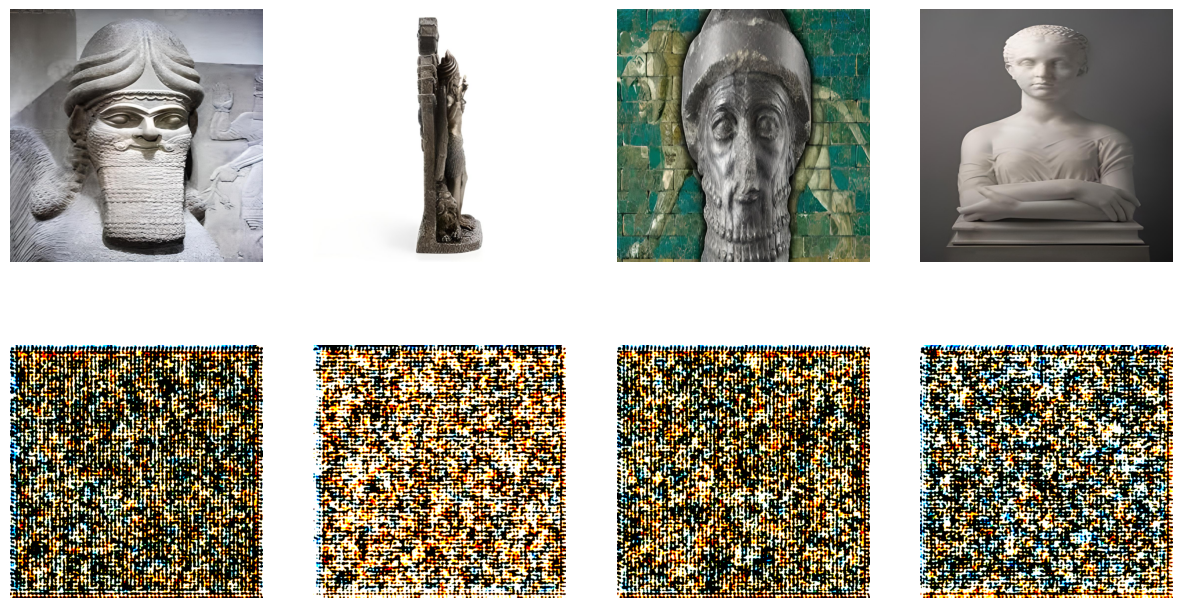

FID: 426.46 | IS: 1.53±0.23
SSIM: 0.0567 | PSNR: 4.99 dB


Epoch 101:  66%|██████▌   | 40/61 [01:07<00:35,  1.70s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.cuda.amp as amp
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 256

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
# Le U-Net opère sur le tenseur latent de dimension (B, latent_dim, 64, 64)
unet = UNet(in_channels=latent_dim, base_channels=128, context_dim=512).to(device)
scheduler_diff = DiffusionScheduler(timesteps=1000)

# Optimiseur commun pour tous les modules
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(unet.parameters()), lr=1e-4)

def encode_text(text_list):
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=77)
    outputs = text_encoder(**inputs)
    return outputs.last_hidden_state  # (B, L, 512)



# Après la définition des modèles et optimiseur
checkpoint_path = "/content/drive/MyDrive/test_checkpoint/stable_difusion_checkpoint.pth"
start_epoch = 0
best_fid = float('inf')

# Chargement du checkpoint existant
if os.path.exists(checkpoint_path):
    model_checkpoint = torch.load(checkpoint_path)
    encoder.load_state_dict(model_checkpoint['encoder'])
    decoder.load_state_dict(model_checkpoint['decoder'])
    unet.load_state_dict(model_checkpoint['unet'])
    optimizer.load_state_dict(model_checkpoint['optimizer'])
    start_epoch = model_checkpoint['epoch'] + 1
    best_fid = model_checkpoint['best_fid']
    print(f"Reprise de l'entraînement à partir de l'epoch {start_epoch}")

num_epochs = start_epoch + 50
scaler = amp.GradScaler()
#best_fid = float('inf')
for epoch in range(start_epoch, num_epochs):
    # Entraînement
    encoder.train()
    decoder.train()
    unet.train()
    train_loss = 0.0

    for images, texts in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        optimizer.zero_grad()

        with amp.autocast():
            # Forward pass
            latent = encoder(images)
            text_emb = encode_text(texts).to(device)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)

            # Calcul des pertes
            loss_diff = F.mse_loss(pred_noise, noise)
            loss_recon = F.mse_loss(decoder(latent), images)
            loss = loss_diff + 0.5 * loss_recon  # Poids ajustable

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validation
    encoder.eval()
    decoder.eval()
    unet.eval()
    val_loss = 0.0
    all_real = []
    all_gen = []
    with torch.no_grad():
        for images, texts in val_loader:
            images = images.to(device)
            text_emb = encode_text(texts).to(device)
            # Calcul de la perte (toujours exécuté)
            latent = encoder(images)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)
            loss = F.mse_loss(pred_noise, noise)
            val_loss += loss.item()
            # Génération d'images seulement toutes les 50 epochs
            if (epoch + 1) % 50 == 0:
                gen_images = sample(unet, decoder, scheduler_diff, text_emb, latent_dim, device=device)
                all_real.append(images.cpu())
                all_gen.append(gen_images.cpu())
    # Calcul des métriques seulement toutes les 50 epochs
    if (epoch + 1) % 50 == 0:
        real_images = torch.cat(all_real)
        gen_images = torch.cat(all_gen)
        metrics = calculate_metrics(real_images, gen_images, device)
    else:
        metrics = None
    # Affichage conditionnel
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}")
    if metrics is not None:
        # Visualisation des images
        fig, axs = plt.subplots(2, 4, figsize=(15, 8))
        for i in range(4):
            axs[0, i].imshow(real_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
            axs[1, i].imshow(gen_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
            axs[0, i].axis('off')
            axs[1, i].axis('off')
        plt.show()

        # Affichage des métriques
        print(f"FID: {metrics['fid']:.2f} | IS: {metrics['is'][0]:.2f}±{metrics['is'][1]:.2f}")
        print(f"SSIM: {metrics['ssim']:.4f} | PSNR: {metrics['psnr']:.2f} dB")

        # Sauvegarde du checkpoint après chaque epoch
        model_checkpoint = {
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'unet': unet.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'best_fid': best_fid
        }
        torch.save(model_checkpoint, checkpoint_path)

        # Sauvegarde du meilleur modèle séparément
        if metrics and metrics['fid'] < best_fid:
            best_fid = metrics['fid']
            torch.save(model_checkpoint, "/content/drive/MyDrive/test_checkpoint/stable_difusion_light_v1.pth")

<ipython-input-12-378bf69c0b59>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Reprise de l'entraînement à partir de l'epoch 130


Epoch 131:   0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-12-378bf69c0b59>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-10-acd516ab9a26>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_bar = torch.tensor(self.alpha_bar, device=x.device)[t].view(-1, 1, 1, 1)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(


Epoch 131
Train Loss: 0.7491
Val Loss: 0.7453


Epoch 132: 100%|██████████| 61/61 [01:39<00:00,  1.63s/it]



Epoch 132
Train Loss: 0.7489
Val Loss: 0.7453


Epoch 133: 100%|██████████| 61/61 [01:21<00:00,  1.34s/it]



Epoch 133
Train Loss: 0.7488
Val Loss: 0.7456


Epoch 134: 100%|██████████| 61/61 [01:23<00:00,  1.37s/it]



Epoch 134
Train Loss: 0.7489
Val Loss: 0.7451


Epoch 135: 100%|██████████| 61/61 [01:19<00:00,  1.31s/it]



Epoch 135
Train Loss: 0.7488
Val Loss: 0.7454


Epoch 136: 100%|██████████| 61/61 [01:19<00:00,  1.30s/it]



Epoch 136
Train Loss: 0.7485
Val Loss: 0.7448


Epoch 137: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]



Epoch 137
Train Loss: 0.7484
Val Loss: 0.7450


Epoch 138: 100%|██████████| 61/61 [01:21<00:00,  1.34s/it]



Epoch 138
Train Loss: 0.7485
Val Loss: 0.7453


Epoch 139: 100%|██████████| 61/61 [01:20<00:00,  1.32s/it]



Epoch 139
Train Loss: 0.7482
Val Loss: 0.7446


Epoch 140: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 140
Train Loss: 0.7483
Val Loss: 0.7449


Epoch 141: 100%|██████████| 61/61 [01:23<00:00,  1.37s/it]



Epoch 141
Train Loss: 0.7586
Val Loss: 0.7670


Epoch 142: 100%|██████████| 61/61 [01:19<00:00,  1.30s/it]



Epoch 142
Train Loss: 0.7587
Val Loss: 0.7474


Epoch 143: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]



Epoch 143
Train Loss: 0.7504
Val Loss: 0.7457


Epoch 144: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]



Epoch 144
Train Loss: 0.7491
Val Loss: 0.7452


Epoch 145: 100%|██████████| 61/61 [01:15<00:00,  1.23s/it]



Epoch 145
Train Loss: 0.7488
Val Loss: 0.7457


Epoch 146: 100%|██████████| 61/61 [01:17<00:00,  1.28s/it]



Epoch 146
Train Loss: 0.7492
Val Loss: 0.7452


Epoch 147: 100%|██████████| 61/61 [01:27<00:00,  1.43s/it]



Epoch 147
Train Loss: 0.7484
Val Loss: 0.7453


Epoch 148: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]



Epoch 148
Train Loss: 0.7482
Val Loss: 0.7453


Epoch 149: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]



Epoch 149
Train Loss: 0.7481
Val Loss: 0.7449


Epoch 150: 100%|██████████| 61/61 [01:20<00:00,  1.32s/it]
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 243MB/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmet


Epoch 150
Train Loss: 0.7480
Val Loss: 0.7451


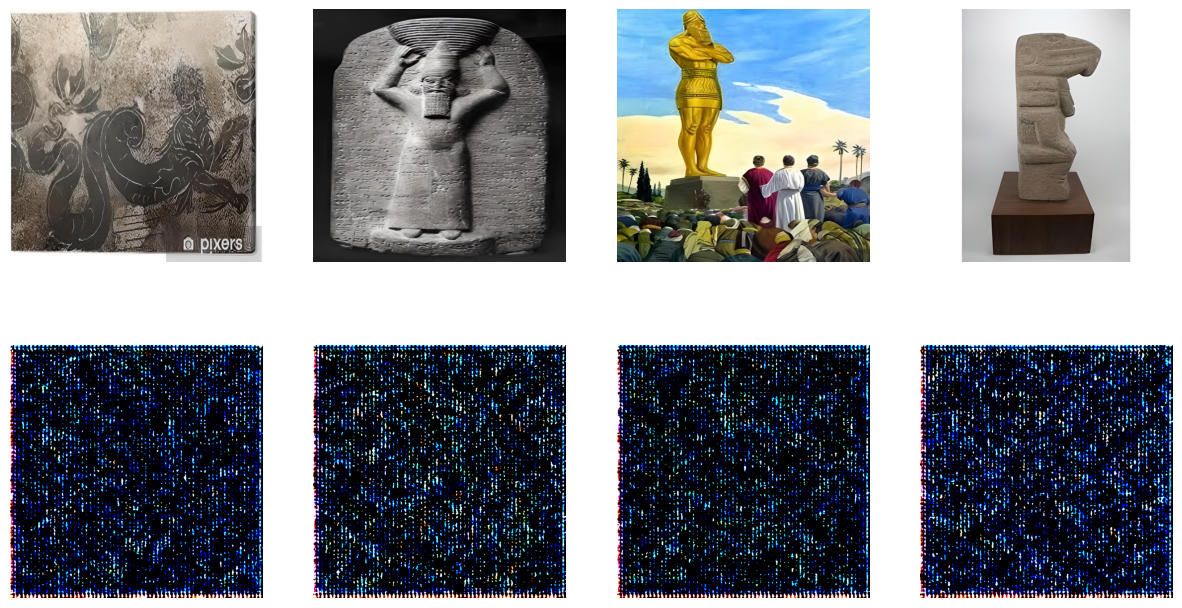

FID: 470.36 | IS: 1.20±0.07
SSIM: 0.0392 | PSNR: 4.88 dB


Epoch 151: 100%|██████████| 61/61 [01:24<00:00,  1.39s/it]



Epoch 151
Train Loss: 0.7480
Val Loss: 0.7449


Epoch 152: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]



Epoch 152
Train Loss: 0.7476
Val Loss: 0.7448


Epoch 153: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]



Epoch 153
Train Loss: 0.7479
Val Loss: 0.7454


Epoch 154: 100%|██████████| 61/61 [01:13<00:00,  1.21s/it]



Epoch 154
Train Loss: 0.7482
Val Loss: 0.7451


Epoch 155: 100%|██████████| 61/61 [01:14<00:00,  1.23s/it]



Epoch 155
Train Loss: 0.7478
Val Loss: 0.7448


Epoch 156: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]



Epoch 156
Train Loss: 0.7477
Val Loss: 0.7444


Epoch 157: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]



Epoch 157
Train Loss: 0.7475
Val Loss: 0.7445


Epoch 158: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]



Epoch 158
Train Loss: 0.7473
Val Loss: 0.7445


Epoch 159: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]



Epoch 159
Train Loss: 0.7474
Val Loss: 0.7444


Epoch 160: 100%|██████████| 61/61 [01:20<00:00,  1.31s/it]



Epoch 160
Train Loss: 0.7473
Val Loss: 0.7444


Epoch 161:  74%|███████▍  | 45/61 [01:04<00:22,  1.43s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.cuda.amp as amp
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 256

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
# Le U-Net opère sur le tenseur latent de dimension (B, latent_dim, 64, 64)
unet = UNet(in_channels=latent_dim, base_channels=128, context_dim=512).to(device)
scheduler_diff = DiffusionScheduler(timesteps=1000)

# Optimiseur commun pour tous les modules
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(unet.parameters()), lr=1e-4)

def encode_text(text_list):
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=77)
    outputs = text_encoder(**inputs)
    return outputs.last_hidden_state  # (B, L, 512)



# Après la définition des modèles et optimiseur
checkpoint_path = "/content/drive/MyDrive/test_checkpoint/stable_difusion_checkpoint.pth"
start_epoch = 0
best_fid = float('inf')

# Chargement du checkpoint existant
if os.path.exists(checkpoint_path):
    model_checkpoint = torch.load(checkpoint_path)
    encoder.load_state_dict(model_checkpoint['encoder'])
    decoder.load_state_dict(model_checkpoint['decoder'])
    unet.load_state_dict(model_checkpoint['unet'])
    optimizer.load_state_dict(model_checkpoint['optimizer'])
    start_epoch = model_checkpoint['epoch'] + 1
    best_fid = model_checkpoint['best_fid']
    print(f"Reprise de l'entraînement à partir de l'epoch {start_epoch}")

num_epochs = start_epoch + 50
scaler = amp.GradScaler()
#best_fid = float('inf')
for epoch in range(start_epoch, num_epochs):
    # Entraînement
    encoder.train()
    decoder.train()
    unet.train()
    train_loss = 0.0

    for images, texts in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        optimizer.zero_grad()

        with amp.autocast():
            # Forward pass
            latent = encoder(images)
            text_emb = encode_text(texts).to(device)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)

            # Calcul des pertes
            loss_diff = F.mse_loss(pred_noise, noise)
            loss_recon = F.mse_loss(decoder(latent), images)
            loss = loss_diff + 0.5 * loss_recon  # Poids ajustable

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validation
    encoder.eval()
    decoder.eval()
    unet.eval()
    val_loss = 0.0
    all_real = []
    all_gen = []
    with torch.no_grad():
        for images, texts in val_loader:
            images = images.to(device)
            text_emb = encode_text(texts).to(device)
            # Calcul de la perte (toujours exécuté)
            latent = encoder(images)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)
            loss = F.mse_loss(pred_noise, noise)
            val_loss += loss.item()
            # Génération d'images seulement toutes les 50 epochs
            if (epoch + 1) % 50 == 0:
                gen_images = sample(unet, decoder, scheduler_diff, text_emb, latent_dim, device=device)
                all_real.append(images.cpu())
                all_gen.append(gen_images.cpu())
    # Calcul des métriques seulement toutes les 50 epochs
    if (epoch + 1) % 50 == 0:
        real_images = torch.cat(all_real)
        gen_images = torch.cat(all_gen)
        metrics = calculate_metrics(real_images, gen_images, device)
    else:
        metrics = None
    # Affichage conditionnel
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}")
    #if metrics is not None or (epoch + 1) % 10 == 0:
    if (epoch + 1) % 10 == 0:
        if metrics is not None:

            # Visualisation des images
            fig, axs = plt.subplots(2, 4, figsize=(15, 8))
            for i in range(4):
                axs[0, i].imshow(real_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[1, i].imshow(gen_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[0, i].axis('off')
                axs[1, i].axis('off')
            plt.show()

            # Affichage des métriques
            print(f"FID: {metrics['fid']:.2f} | IS: {metrics['is'][0]:.2f}±{metrics['is'][1]:.2f}")
            print(f"SSIM: {metrics['ssim']:.4f} | PSNR: {metrics['psnr']:.2f} dB")

        # Sauvegarde du checkpoint après chaque epoch
        model_checkpoint = {
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'unet': unet.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'best_fid': best_fid
        }
        torch.save(model_checkpoint, checkpoint_path)

        # Sauvegarde du meilleur modèle séparément
        if metrics and metrics['fid'] < best_fid:
            best_fid = metrics['fid']
            torch.save(model_checkpoint, "/content/drive/MyDrive/test_checkpoint/stable_difusion_light_v1.pth")

<ipython-input-12-b01e54749167>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Reprise de l'entraînement à partir de l'epoch 190


Epoch 191:   0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-12-b01e54749167>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-10-acd516ab9a26>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_bar = torch.tensor(self.alpha_bar, device=x.device)[t].view(-1, 1, 1, 1)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(


Epoch 191
Train Loss: 0.7463
Val Loss: 0.7435


Epoch 192: 100%|██████████| 61/61 [01:31<00:00,  1.50s/it]



Epoch 192
Train Loss: 0.7461
Val Loss: 0.7434


Epoch 193: 100%|██████████| 61/61 [01:23<00:00,  1.37s/it]



Epoch 193
Train Loss: 0.7469
Val Loss: 0.7447


Epoch 194: 100%|██████████| 61/61 [01:28<00:00,  1.45s/it]



Epoch 194
Train Loss: 0.7467
Val Loss: 0.7431


Epoch 195: 100%|██████████| 61/61 [01:21<00:00,  1.34s/it]



Epoch 195
Train Loss: 0.7464
Val Loss: 0.7438


Epoch 196: 100%|██████████| 61/61 [01:31<00:00,  1.50s/it]



Epoch 196
Train Loss: 0.7476
Val Loss: 0.7438


Epoch 197: 100%|██████████| 61/61 [01:23<00:00,  1.37s/it]



Epoch 197
Train Loss: 0.7474
Val Loss: 0.7434


Epoch 198: 100%|██████████| 61/61 [01:23<00:00,  1.37s/it]



Epoch 198
Train Loss: 0.7466
Val Loss: 0.7438


Epoch 199: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]



Epoch 199
Train Loss: 0.7461
Val Loss: 0.7440


Epoch 200: 100%|██████████| 61/61 [01:25<00:00,  1.40s/it]
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 44.4MB/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchme


Epoch 200
Train Loss: 0.7460
Val Loss: 0.7433


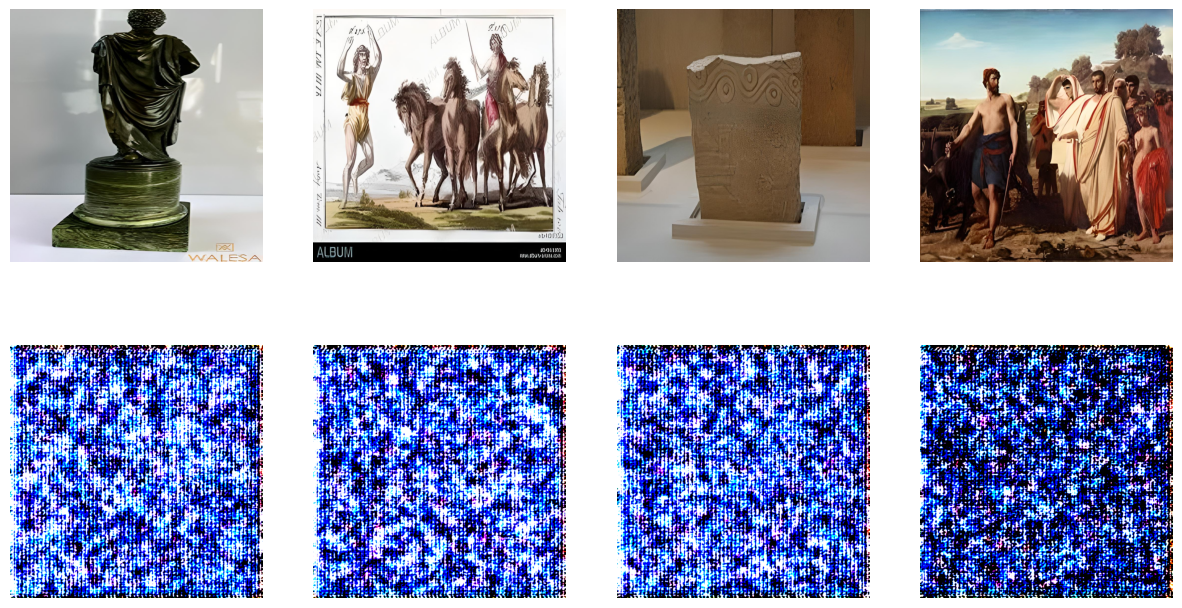

FID: 436.39 | IS: 1.19±0.14
SSIM: 0.0623 | PSNR: 4.30 dB


Epoch 201: 100%|██████████| 61/61 [01:20<00:00,  1.32s/it]



Epoch 201
Train Loss: 0.7459
Val Loss: 0.7432


Epoch 202: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]



Epoch 202
Train Loss: 0.7470
Val Loss: 0.7434


Epoch 203: 100%|██████████| 61/61 [01:21<00:00,  1.34s/it]



Epoch 203
Train Loss: 0.7463
Val Loss: 0.7443


Epoch 204: 100%|██████████| 61/61 [01:36<00:00,  1.58s/it]



Epoch 204
Train Loss: 0.7463
Val Loss: 0.7446


Epoch 205: 100%|██████████| 61/61 [01:23<00:00,  1.37s/it]



Epoch 205
Train Loss: 0.7460
Val Loss: 0.7432


Epoch 206: 100%|██████████| 61/61 [01:26<00:00,  1.42s/it]



Epoch 206
Train Loss: 0.7459
Val Loss: 0.7434


Epoch 207: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 207
Train Loss: 0.7455
Val Loss: 0.7438


Epoch 208: 100%|██████████| 61/61 [01:30<00:00,  1.48s/it]



Epoch 208
Train Loss: 0.7456
Val Loss: 0.7429


Epoch 209: 100%|██████████| 61/61 [01:26<00:00,  1.41s/it]



Epoch 209
Train Loss: 0.7456
Val Loss: 0.7431


Epoch 210: 100%|██████████| 61/61 [01:26<00:00,  1.42s/it]



Epoch 210
Train Loss: 0.7466
Val Loss: 0.7434


Epoch 211: 100%|██████████| 61/61 [01:21<00:00,  1.34s/it]



Epoch 211
Train Loss: 0.7457
Val Loss: 0.7432


Epoch 212: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]



Epoch 212
Train Loss: 0.7459
Val Loss: 0.7430


Epoch 213: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 213
Train Loss: 0.7456
Val Loss: 0.7432


Epoch 214: 100%|██████████| 61/61 [01:20<00:00,  1.31s/it]



Epoch 214
Train Loss: 0.7455
Val Loss: 0.7428


Epoch 215: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]



Epoch 215
Train Loss: 0.7454
Val Loss: 0.7424


Epoch 216: 100%|██████████| 61/61 [01:20<00:00,  1.32s/it]



Epoch 216
Train Loss: 0.7455
Val Loss: 0.7427


Epoch 217: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]



Epoch 217
Train Loss: 0.7454
Val Loss: 0.7430


Epoch 218: 100%|██████████| 61/61 [01:22<00:00,  1.35s/it]



Epoch 218
Train Loss: 0.7457
Val Loss: 0.7428


Epoch 219: 100%|██████████| 61/61 [01:19<00:00,  1.30s/it]



Epoch 219
Train Loss: 0.7456
Val Loss: 0.7432


Epoch 220: 100%|██████████| 61/61 [01:22<00:00,  1.36s/it]



Epoch 220
Train Loss: 0.7455
Val Loss: 0.7424


Epoch 221: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]



Epoch 221
Train Loss: 0.7453
Val Loss: 0.7434


Epoch 222: 100%|██████████| 61/61 [01:34<00:00,  1.55s/it]



Epoch 222
Train Loss: 0.7453
Val Loss: 0.7435


Epoch 223: 100%|██████████| 61/61 [01:21<00:00,  1.34s/it]



Epoch 223
Train Loss: 0.7455
Val Loss: 0.7431


Epoch 224: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]



Epoch 224
Train Loss: 0.7453
Val Loss: 0.7429


Epoch 225: 100%|██████████| 61/61 [01:29<00:00,  1.47s/it]



Epoch 225
Train Loss: 0.7457
Val Loss: 0.7430


Epoch 226: 100%|██████████| 61/61 [01:24<00:00,  1.38s/it]



Epoch 226
Train Loss: 0.7453
Val Loss: 0.7427


Epoch 227: 100%|██████████| 61/61 [01:22<00:00,  1.35s/it]



Epoch 227
Train Loss: 0.7453
Val Loss: 0.7431


Epoch 228: 100%|██████████| 61/61 [01:25<00:00,  1.40s/it]



Epoch 228
Train Loss: 0.7453
Val Loss: 0.7429


Epoch 229: 100%|██████████| 61/61 [01:21<00:00,  1.34s/it]



Epoch 229
Train Loss: 0.7458
Val Loss: 0.7430


Epoch 230: 100%|██████████| 61/61 [01:20<00:00,  1.32s/it]



Epoch 230
Train Loss: 0.7465
Val Loss: 0.7426


Epoch 231: 100%|██████████| 61/61 [01:25<00:00,  1.41s/it]



Epoch 231
Train Loss: 0.7472
Val Loss: 0.7428


Epoch 232: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]



Epoch 232
Train Loss: 0.7457
Val Loss: 0.7433


Epoch 233: 100%|██████████| 61/61 [01:20<00:00,  1.32s/it]



Epoch 233
Train Loss: 0.7458
Val Loss: 0.7430


Epoch 234: 100%|██████████| 61/61 [01:19<00:00,  1.30s/it]



Epoch 234
Train Loss: 0.7454
Val Loss: 0.7430


Epoch 235: 100%|██████████| 61/61 [01:20<00:00,  1.32s/it]



Epoch 235
Train Loss: 0.7484
Val Loss: 0.7464


Epoch 236: 100%|██████████| 61/61 [01:19<00:00,  1.31s/it]



Epoch 236
Train Loss: 0.7469
Val Loss: 0.7434


Epoch 237: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]



Epoch 237
Train Loss: 0.7459
Val Loss: 0.7436


Epoch 238: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]



Epoch 238
Train Loss: 0.7462
Val Loss: 0.7438


Epoch 239: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 239
Train Loss: 0.7454
Val Loss: 0.7426


Epoch 240: 100%|██████████| 61/61 [01:15<00:00,  1.23s/it]



Epoch 240
Train Loss: 0.7452
Val Loss: 0.7436


In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.cuda.amp as amp
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 256

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
# Le U-Net opère sur le tenseur latent de dimension (B, latent_dim, 64, 64)
unet = UNet(in_channels=latent_dim, base_channels=128, context_dim=512).to(device)
scheduler_diff = DiffusionScheduler(timesteps=1000)

# Optimiseur commun pour tous les modules
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(unet.parameters()), lr=1e-3)

def encode_text(text_list):
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=77)
    outputs = text_encoder(**inputs)
    return outputs.last_hidden_state  # (B, L, 512)



# Après la définition des modèles et optimiseur
checkpoint_path = "/content/drive/MyDrive/test_checkpoint/stable_difusion_checkpoint.pth"
start_epoch = 0
best_fid = float('inf')

# Chargement du checkpoint existant
if os.path.exists(checkpoint_path):
    model_checkpoint = torch.load(checkpoint_path)
    encoder.load_state_dict(model_checkpoint['encoder'])
    decoder.load_state_dict(model_checkpoint['decoder'])
    unet.load_state_dict(model_checkpoint['unet'])
    optimizer.load_state_dict(model_checkpoint['optimizer'])
    start_epoch = model_checkpoint['epoch'] + 1
    best_fid = model_checkpoint['best_fid']
    print(f"Reprise de l'entraînement à partir de l'epoch {start_epoch}")

num_epochs = start_epoch + 50
scaler = amp.GradScaler()
#best_fid = float('inf')
for epoch in range(start_epoch, num_epochs):
    # Entraînement
    encoder.train()
    decoder.train()
    unet.train()
    train_loss = 0.0

    for images, texts in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        optimizer.zero_grad()

        with amp.autocast():
            # Forward pass
            latent = encoder(images)
            text_emb = encode_text(texts).to(device)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)

            # Calcul des pertes
            loss_diff = F.mse_loss(pred_noise, noise)
            loss_recon = F.mse_loss(decoder(latent), images)
            loss = loss_diff + 0.5 * loss_recon  # Poids ajustable

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validation
    encoder.eval()
    decoder.eval()
    unet.eval()
    val_loss = 0.0
    all_real = []
    all_gen = []
    with torch.no_grad():
        for images, texts in val_loader:
            images = images.to(device)
            text_emb = encode_text(texts).to(device)
            # Calcul de la perte (toujours exécuté)
            latent = encoder(images)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)
            loss = F.mse_loss(pred_noise, noise)
            val_loss += loss.item()
            # Génération d'images seulement toutes les 50 epochs
            if (epoch + 1) % 50 == 0:
                gen_images = sample(unet, decoder, scheduler_diff, text_emb, latent_dim, device=device)
                all_real.append(images.cpu())
                all_gen.append(gen_images.cpu())
    # Calcul des métriques seulement toutes les 50 epochs
    if (epoch + 1) % 50 == 0:
        real_images = torch.cat(all_real)
        gen_images = torch.cat(all_gen)
        metrics = calculate_metrics(real_images, gen_images, device)
    else:
        metrics = None
    # Affichage conditionnel
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}")
    #if metrics is not None or (epoch + 1) % 10 == 0:
    if (epoch + 1) % 10 == 0:
        if metrics is not None:

            # Visualisation des images
            fig, axs = plt.subplots(2, 4, figsize=(15, 8))
            for i in range(4):
                axs[0, i].imshow(real_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[1, i].imshow(gen_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[0, i].axis('off')
                axs[1, i].axis('off')
            plt.show()

            # Affichage des métriques
            print(f"FID: {metrics['fid']:.2f} | IS: {metrics['is'][0]:.2f}±{metrics['is'][1]:.2f}")
            print(f"SSIM: {metrics['ssim']:.4f} | PSNR: {metrics['psnr']:.2f} dB")

        # Sauvegarde du checkpoint après chaque 10 epoch
        model_checkpoint = {
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'unet': unet.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'best_fid': best_fid
        }
        torch.save(model_checkpoint, checkpoint_path)

        # Sauvegarde du meilleur modèle séparément
        if metrics and metrics['fid'] < best_fid:
            best_fid = metrics['fid']
            torch.save(model_checkpoint, "/content/drive/MyDrive/test_checkpoint/stable_difusion_light_v1.pth")

In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.cuda.amp as amp
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 256

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
# Le U-Net opère sur le tenseur latent de dimension (B, latent_dim, 64, 64)
unet = UNet(in_channels=latent_dim, base_channels=128, context_dim=512).to(device)
scheduler_diff = DiffusionScheduler(timesteps=1000)

# Optimiseur commun pour tous les modules
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(unet.parameters()), lr=1e-3)

def encode_text(text_list):
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=77)
    outputs = text_encoder(**inputs)
    return outputs.last_hidden_state  # (B, L, 512)



# Après la définition des modèles et optimiseur
checkpoint_path = "/content/drive/MyDrive/test_checkpoint/stable_difusion_checkpoint.pth"
start_epoch = 0
best_fid = float('inf')

# Chargement du checkpoint existant
if os.path.exists(checkpoint_path):
    model_checkpoint = torch.load(checkpoint_path)
    encoder.load_state_dict(model_checkpoint['encoder'])
    decoder.load_state_dict(model_checkpoint['decoder'])
    unet.load_state_dict(model_checkpoint['unet'])
    optimizer.load_state_dict(model_checkpoint['optimizer'])
    start_epoch = model_checkpoint['epoch'] + 1
    best_fid = model_checkpoint['best_fid']
    print(f"Reprise de l'entraînement à partir de l'epoch {start_epoch}")

num_epochs = start_epoch + 50
scaler = amp.GradScaler()
#best_fid = float('inf')
for epoch in range(start_epoch, num_epochs):
    # Entraînement
    encoder.train()
    decoder.train()
    unet.train()
    train_loss = 0.0

    for images, texts in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        optimizer.zero_grad()

        with amp.autocast():
            # Forward pass
            latent = encoder(images)
            text_emb = encode_text(texts).to(device)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)

            # Calcul des pertes
            loss_diff = F.mse_loss(pred_noise, noise)
            loss_recon = F.mse_loss(decoder(latent), images)
            loss = loss_diff + 0.5 * loss_recon  # Poids ajustable

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validation
    encoder.eval()
    decoder.eval()
    unet.eval()
    val_loss = 0.0
    all_real = []
    all_gen = []
    with torch.no_grad():
        for images, texts in val_loader:
            images = images.to(device)
            text_emb = encode_text(texts).to(device)
            # Calcul de la perte (toujours exécuté)
            latent = encoder(images)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)
            loss = F.mse_loss(pred_noise, noise)
            val_loss += loss.item()
            # Génération d'images seulement toutes les 50 epochs
            if (epoch + 1) % 50 == 0:
                gen_images = sample(unet, decoder, scheduler_diff, text_emb, latent_dim, device=device)
                all_real.append(images.cpu())
                all_gen.append(gen_images.cpu())
    # Calcul des métriques seulement toutes les 50 epochs
    if (epoch + 1) % 50 == 0:
        real_images = torch.cat(all_real)
        gen_images = torch.cat(all_gen)
        metrics = calculate_metrics(real_images, gen_images, device)
    else:
        metrics = None
    # Affichage conditionnel
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}")
    #if metrics is not None or (epoch + 1) % 10 == 0:
    if (epoch + 1) % 10 == 0:
        if metrics is not None:

            # Visualisation des images
            fig, axs = plt.subplots(2, 4, figsize=(15, 8))
            for i in range(4):
                axs[0, i].imshow(real_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[1, i].imshow(gen_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[0, i].axis('off')
                axs[1, i].axis('off')
            plt.show()

            # Affichage des métriques
            print(f"FID: {metrics['fid']:.2f} | IS: {metrics['is'][0]:.2f}±{metrics['is'][1]:.2f}")
            print(f"SSIM: {metrics['ssim']:.4f} | PSNR: {metrics['psnr']:.2f} dB")

        # Sauvegarde du checkpoint après chaque 10 epoch
        model_checkpoint = {
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'unet': unet.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'best_fid': best_fid
        }
        torch.save(model_checkpoint, checkpoint_path)

        # Sauvegarde du meilleur modèle séparément
        if metrics and metrics['fid'] < best_fid:
            best_fid = metrics['fid']
            torch.save(model_checkpoint, "/content/drive/MyDrive/test_checkpoint/stable_difusion_light_v1.pth")

<ipython-input-13-7bbad65bd4f2>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Reprise de l'entraînement à partir de l'epoch 240


Epoch 241:   0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-13-7bbad65bd4f2>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-10-acd516ab9a26>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_bar = torch.tensor(self.alpha_bar, device=x.device)[t].view(-1, 1, 1, 1)
Epoch 241: 100%|██████████| 61/61 [01:28<00:00,  1.45s/it]



Epoch 241
Train Loss: 0.7455
Val Loss: 0.7424


Epoch 242: 100%|██████████| 61/61 [01:25<00:00,  1.40s/it]



Epoch 242
Train Loss: 0.7456
Val Loss: 0.7422


Epoch 243: 100%|██████████| 61/61 [01:14<00:00,  1.23s/it]



Epoch 243
Train Loss: 0.7453
Val Loss: 0.7427


Epoch 244: 100%|██████████| 61/61 [01:27<00:00,  1.43s/it]



Epoch 244
Train Loss: 0.7451
Val Loss: 0.7431


Epoch 245: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 245
Train Loss: 0.7450
Val Loss: 0.7430


Epoch 246: 100%|██████████| 61/61 [01:35<00:00,  1.57s/it]



Epoch 246
Train Loss: 0.7451
Val Loss: 0.7426


Epoch 247: 100%|██████████| 61/61 [01:15<00:00,  1.23s/it]



Epoch 247
Train Loss: 0.7451
Val Loss: 0.7429


Epoch 248: 100%|██████████| 61/61 [01:14<00:00,  1.23s/it]



Epoch 248
Train Loss: 0.7453
Val Loss: 0.7429


Epoch 249: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]



Epoch 249
Train Loss: 0.7452
Val Loss: 0.7430


Epoch 250: 100%|██████████| 61/61 [01:14<00:00,  1.22s/it]


<ipython-input-13-a1b732e69ca5>:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Reprise de l'entraînement à partir de l'epoch 250


Epoch 251:   0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-13-a1b732e69ca5>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-10-acd516ab9a26>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_bar = torch.tensor(self.alpha_bar, device=x.device)[t].view(-1, 1, 1, 1)
Epoch 251: 100%|██████████| 61/61 [01:21<00:00,  1.34s/it]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



Epoch 251
Train Loss: 0.7449
Val Loss: 0.7429


Epoch 252: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 252
Train Loss: 0.7450
Val Loss: 0.7427


Epoch 253: 100%|██████████| 61/61 [01:22<00:00,  1.35s/it]



Epoch 253
Train Loss: 0.7449
Val Loss: 0.7429


Epoch 254: 100%|██████████| 61/61 [01:14<00:00,  1.21s/it]



Epoch 254
Train Loss: 0.7450
Val Loss: 0.7430


Epoch 255: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]



Epoch 255
Train Loss: 0.7452
Val Loss: 0.7428


Epoch 256: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]



Epoch 256
Train Loss: 0.7449
Val Loss: 0.7422


Epoch 257: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]



Epoch 257
Train Loss: 0.7455
Val Loss: 0.7431


Epoch 258: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]



Epoch 258
Train Loss: 0.7452
Val Loss: 0.7425


Epoch 259: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]



Epoch 259
Train Loss: 0.7457
Val Loss: 0.7437


Epoch 260: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 260
Train Loss: 0.7452
Val Loss: 0.7431


Epoch 261: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 261
Train Loss: 0.7450
Val Loss: 0.7429


Epoch 262: 100%|██████████| 61/61 [01:14<00:00,  1.23s/it]



Epoch 262
Train Loss: 0.7449
Val Loss: 0.7423


Epoch 263: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]



Epoch 263
Train Loss: 0.7449
Val Loss: 0.7424


Epoch 264: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 264
Train Loss: 0.7448
Val Loss: 0.7431


Epoch 265: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 265
Train Loss: 0.7449
Val Loss: 0.7430


Epoch 266: 100%|██████████| 61/61 [01:15<00:00,  1.23s/it]



Epoch 266
Train Loss: 0.7449
Val Loss: 0.7423


Epoch 267: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]



Epoch 267
Train Loss: 0.7450
Val Loss: 0.7428


Epoch 268: 100%|██████████| 61/61 [01:15<00:00,  1.23s/it]



Epoch 268
Train Loss: 0.7450
Val Loss: 0.7432


Epoch 269: 100%|██████████| 61/61 [01:19<00:00,  1.31s/it]



Epoch 269
Train Loss: 0.7448
Val Loss: 0.7426


Epoch 270: 100%|██████████| 61/61 [01:19<00:00,  1.30s/it]



Epoch 270
Train Loss: 0.7446
Val Loss: 0.7425


Epoch 271: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]



Epoch 271
Train Loss: 0.7448
Val Loss: 0.7430


Epoch 272: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]



Epoch 272
Train Loss: 0.7448
Val Loss: 0.7428


Epoch 273: 100%|██████████| 61/61 [01:17<00:00,  1.28s/it]



Epoch 273
Train Loss: 0.7449
Val Loss: 0.7429


Epoch 274: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]



Epoch 274
Train Loss: 0.7447
Val Loss: 0.7431


Epoch 275: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 275
Train Loss: 0.7448
Val Loss: 0.7425


Epoch 276: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]



Epoch 276
Train Loss: 0.7448
Val Loss: 0.7424


Epoch 277: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]



Epoch 277
Train Loss: 0.7447
Val Loss: 0.7426


Epoch 278: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]



Epoch 278
Train Loss: 0.7447
Val Loss: 0.7428


Epoch 279: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]



Epoch 279
Train Loss: 0.7449
Val Loss: 0.7429


Epoch 280: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 280
Train Loss: 0.7454
Val Loss: 0.7432


Epoch 281: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]



Epoch 281
Train Loss: 0.7450
Val Loss: 0.7427


Epoch 282: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]



Epoch 282
Train Loss: 0.7449
Val Loss: 0.7429


Epoch 283: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]



Epoch 283
Train Loss: 0.7452
Val Loss: 0.7426


Epoch 284: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 284
Train Loss: 0.7449
Val Loss: 0.7426


Epoch 285: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]



Epoch 285
Train Loss: 0.7449
Val Loss: 0.7432


Epoch 286: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]



Epoch 286
Train Loss: 0.7451
Val Loss: 0.7428


Epoch 287: 100%|██████████| 61/61 [01:13<00:00,  1.21s/it]



Epoch 287
Train Loss: 0.7448
Val Loss: 0.7425


Epoch 288: 100%|██████████| 61/61 [01:17<00:00,  1.28s/it]



Epoch 288
Train Loss: 0.7448
Val Loss: 0.7428


Epoch 289: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]



Epoch 289
Train Loss: 0.7463
Val Loss: 0.7453


Epoch 290: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]



Epoch 290
Train Loss: 0.7448
Val Loss: 0.7429


Epoch 291: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]



Epoch 291
Train Loss: 0.7464
Val Loss: 0.7429


Epoch 292: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]



Epoch 292
Train Loss: 0.7454
Val Loss: 0.7426


Epoch 293: 100%|██████████| 61/61 [01:13<00:00,  1.20s/it]



Epoch 293
Train Loss: 0.7449
Val Loss: 0.7427


Epoch 294: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]



Epoch 294
Train Loss: 0.7447
Val Loss: 0.7427


Epoch 295: 100%|██████████| 61/61 [01:12<00:00,  1.19s/it]



Epoch 295
Train Loss: 0.7446
Val Loss: 0.7425


Epoch 296: 100%|██████████| 61/61 [01:15<00:00,  1.23s/it]



Epoch 296
Train Loss: 0.7446
Val Loss: 0.7433


Epoch 297: 100%|██████████| 61/61 [01:14<00:00,  1.23s/it]



Epoch 297
Train Loss: 0.7448
Val Loss: 0.7431


Epoch 298: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]



Epoch 298
Train Loss: 0.7448
Val Loss: 0.7432


Epoch 299: 100%|██████████| 61/61 [01:14<00:00,  1.22s/it]



Epoch 299
Train Loss: 0.7451
Val Loss: 0.7429


Epoch 300: 100%|██████████| 61/61 [01:14<00:00,  1.22s/it]
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 128MB/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmet


Epoch 300
Train Loss: 0.7449
Val Loss: 0.7428


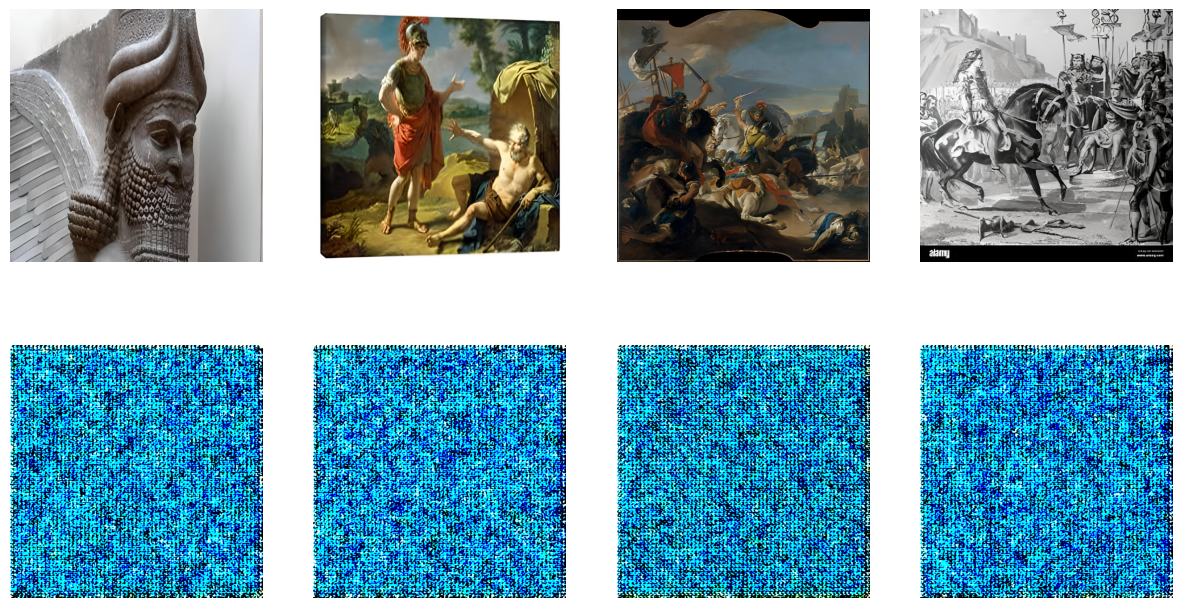

FID: 516.43 | IS: 1.12±0.06
SSIM: 0.0292 | PSNR: 4.63 dB


In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.cuda.amp as amp
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
latent_dim = 256

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
# Le U-Net opère sur le tenseur latent de dimension (B, latent_dim, 64, 64)
unet = UNet(in_channels=latent_dim, base_channels=128, context_dim=512).to(device)
scheduler_diff = DiffusionScheduler(timesteps=1000)

# Optimiseur commun pour tous les modules
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(unet.parameters()), lr=1e-3)

def encode_text(text_list):
    inputs = tokenizer(text_list, return_tensors="pt", padding=True, truncation=True, max_length=77)
    outputs = text_encoder(**inputs)
    return outputs.last_hidden_state  # (B, L, 512)



# Après la définition des modèles et optimiseur
checkpoint_path = "/content/drive/MyDrive/test_checkpoint/stable_difusion_checkpoint.pth"
start_epoch = 0
best_fid = float('inf')

# Chargement du checkpoint existant
if os.path.exists(checkpoint_path):
    model_checkpoint = torch.load(checkpoint_path)
    encoder.load_state_dict(model_checkpoint['encoder'])
    decoder.load_state_dict(model_checkpoint['decoder'])
    unet.load_state_dict(model_checkpoint['unet'])
    optimizer.load_state_dict(model_checkpoint['optimizer'])
    start_epoch = model_checkpoint['epoch'] + 1
    best_fid = model_checkpoint['best_fid']
    print(f"Reprise de l'entraînement à partir de l'epoch {start_epoch}")

num_epochs = start_epoch + 50
scaler = amp.GradScaler()
#best_fid = float('inf')
for epoch in range(start_epoch, num_epochs):
    # Entraînement
    encoder.train()
    decoder.train()
    unet.train()
    train_loss = 0.0

    for images, texts in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        optimizer.zero_grad()

        with amp.autocast():
            # Forward pass
            latent = encoder(images)
            text_emb = encode_text(texts).to(device)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)

            # Calcul des pertes
            loss_diff = F.mse_loss(pred_noise, noise)
            loss_recon = F.mse_loss(decoder(latent), images)
            loss = loss_diff + 0.5 * loss_recon  # Poids ajustable

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validation
    encoder.eval()
    decoder.eval()
    unet.eval()
    val_loss = 0.0
    all_real = []
    all_gen = []
    with torch.no_grad():
        for images, texts in val_loader:
            images = images.to(device)
            text_emb = encode_text(texts).to(device)
            # Calcul de la perte (toujours exécuté)
            latent = encoder(images)
            t = torch.randint(0, 1000, (images.size(0),)).to(device)
            noisy_latent, noise = scheduler_diff.add_noise(latent, t)
            pred_noise = unet(noisy_latent, text_emb)
            loss = F.mse_loss(pred_noise, noise)
            val_loss += loss.item()
            # Génération d'images seulement toutes les 50 epochs
            if (epoch + 1) % 50 == 0:
                gen_images = sample(unet, decoder, scheduler_diff, text_emb, latent_dim, device=device)
                all_real.append(images.cpu())
                all_gen.append(gen_images.cpu())
    # Calcul des métriques seulement toutes les 50 epochs
    if (epoch + 1) % 50 == 0:
        real_images = torch.cat(all_real)
        gen_images = torch.cat(all_gen)
        metrics = calculate_metrics(real_images, gen_images, device)
    else:
        metrics = None
    # Affichage conditionnel
    print(f"\nEpoch {epoch+1}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}")
    #if metrics is not None or (epoch + 1) % 10 == 0:
    if (epoch + 1) % 10 == 0:
        if metrics is not None:

            # Visualisation des images
            fig, axs = plt.subplots(2, 4, figsize=(15, 8))
            for i in range(4):
                axs[0, i].imshow(real_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[1, i].imshow(gen_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
                axs[0, i].axis('off')
                axs[1, i].axis('off')
            plt.show()

            # Affichage des métriques
            print(f"FID: {metrics['fid']:.2f} | IS: {metrics['is'][0]:.2f}±{metrics['is'][1]:.2f}")
            print(f"SSIM: {metrics['ssim']:.4f} | PSNR: {metrics['psnr']:.2f} dB")

        # Sauvegarde du checkpoint après chaque 10 epoch
        model_checkpoint = {
            'encoder': encoder.state_dict(),
            'decoder': decoder.state_dict(),
            'unet': unet.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'best_fid': best_fid
        }
        torch.save(model_checkpoint, checkpoint_path)

        # Sauvegarde du meilleur modèle séparément
        if metrics and metrics['fid'] < best_fid:
            best_fid = metrics['fid']
            torch.save(model_checkpoint, "/content/drive/MyDrive/test_checkpoint/stable_difusion_light_v1.pth")

In [ ]:
def evaluate_test_set(model, decoder, test_loader, device):
    model.eval()
    all_real = []
    all_gen = []

    with torch.no_grad():
        for images, texts in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            text_emb = encode_text(texts).to(device)
            gen_images = sample(unet, decoder, scheduler_diff, text_emb, latent_dim, device=device)

            all_real.append(images.cpu())
            all_gen.append(gen_images.cpu())

    real_images = torch.cat(all_real)
    gen_images = torch.cat(all_gen)
    return calculate_metrics(real_images, gen_images, device)

# Chargement du meilleur modèle
checkpoint = torch.load("/content/drive/MyDrive/test_checkpoint/stable_difusion_light_v1.pth")
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
unet.load_state_dict(checkpoint['unet'])

# Calcul des métriques finales
test_metrics = evaluate_test_set(unet, decoder, test_loader, device)
print("\nFinal Test Metrics:")
print(f"FID: {test_metrics['fid']:.2f} | IS: {test_metrics['is'][0]:.2f}±{test_metrics['is'][1]:.2f}")
print(f"SSIM: {test_metrics['ssim']:.4f} | PSNR: {test_metrics['psnr']:.2f} dB")

Testing: 100%|██████████| 8/8 [03:46<00:00, 28.27s/it]



Final Test Metrics:
FID: 404.35 | IS: 1.21±0.16
SSIM: 0.1620 | PSNR: 4.78 dB
